# SCimilarity search for IPF derived myofibroblasts-similar cells across 22.7M cells
The goal of this tutorial is to familiarize users with SCimilarity's basic cell search function.

- System requirements
   - At least 64GB of RAM
   - SCimilarity package installed
 - Note: these are large files. Ddownloading and processing can take a several minutes.

## 0. Required software and data
Things you need for this demo:

 0. SCimilarity package should already be installed

 1. Cell Query model

 2. Query data
    - We will use [Adams et al., 2020](https://www.science.org/doi/10.1126/sciadv.aba1983?url_ver=Z39.88-2003&rfr_id=ori:rid:crossref.org&rfr_dat=cr_pub%20%200pubmed) healthy and IPF lung scRNA-seq data
    - GEO Source: [GSE136831](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE136831) (~2.5GB)


### Download tutorial data and models
Download the tutorial data, a subsample of GSE136831, from [Zenodo](https://zenodo.org):

- [Download tutorial data](https://zenodo.org/record/8242083)
- [Download SCimilarity models](https://zenodo.org/record/8240464)

In [1]:
# Environment settings
import scanpy as sc
from matplotlib import pyplot as plt

sc.set_figure_params(dpi=100)
plt.rcParams['figure.figsize'] = [6, 4] 
plt.rcParams['figure.autolayout'] = True

import warnings
warnings.filterwarnings('ignore')

## 1. Prepare for SCimilarity: Import and normalize data

In [2]:
from scimilarity.utils import lognorm_counts, align_dataset
from scimilarity import CellQuery

### Import SCimilarity - Cell query object

In [3]:
## TODO
## RESTRUCTURE THE MODEL PATHS FOR DOWNLOAD FILES

# If the models haven't been downloaded please uncomment and run the two command below
#!curl -L -o /models/query_model_v1.tar.gz https://zenodo.org/record/8240464/files/query_model_v1.tar.gz?download=1
#!tar -xzvf /models/query_model_v1.tar.gz

In [4]:
# Instantiate the CellQuery object.
# Replace model_path with your local file path.
model_path = '/models/model_v1'
cq = CellQuery(model_path)

### Load scRNA-seq data

In [5]:
# To Download the demo data to the data/ directory uncomment and run the command below
#! curl -L -o "{download_dir}/GSE136831_subsample.h5ad" https://zenodo.org/record/8242083/files/GSE136831_subsample.h5ad?download=1

In [6]:
# Load the tutorial data.
# Replace data_path with your local file path.
data_path = '../data/GSE136831_subsample.h5ad'
adams = sc.read(data_path)

### SCimilarity pre-processing
SCimilarity requires new data to be processed in a specific way that matches how the model was trained. 

#### Match feature space with SCimilarity models 
SCimilarity's gene expression ordering is fixed. New data should be re-orderd to match that. Genes that are not present in the new data will be zero filled to comply to the expected structure. Genes that are not present in SCimilarity's gene ordering will be filtered out. 

Note: SCimilarity was trained with high data dropout to increase robustness to differences in gene lists. 

In [7]:
adams = align_dataset(adams, cq.gene_order)

#### Normalize data consistent with SCimilarity
It is important to match Scimilarity's normalization so that the data matches the lognorm tp10k procedure used during model training.

In [8]:
adams = lognorm_counts(adams)

With these simple steps, the data is now ready for SCimilarity. We are able to filter cells later (even after embedding) because SCimilarity handles each cell indepdendently and can skip highly variable gene selection altogether.

## 2. Compute embeddings
Using the already trained models, SCimilarity can embed your new dataset. 

In [9]:
adams.obsm['X_scimilarity'] = cq.get_embeddings(adams.X)

### Compute visualization of embeddings

In [10]:
sc.pp.neighbors(adams, use_rep='X_scimilarity')
sc.tl.umap(adams)

### Visualize author annotations on the SCimilarity embedding
Given that author annotations are derived from a different analysis, seeing author annotations roughly cluster in SCimilarity embedding space gives us confidence in our representation. 

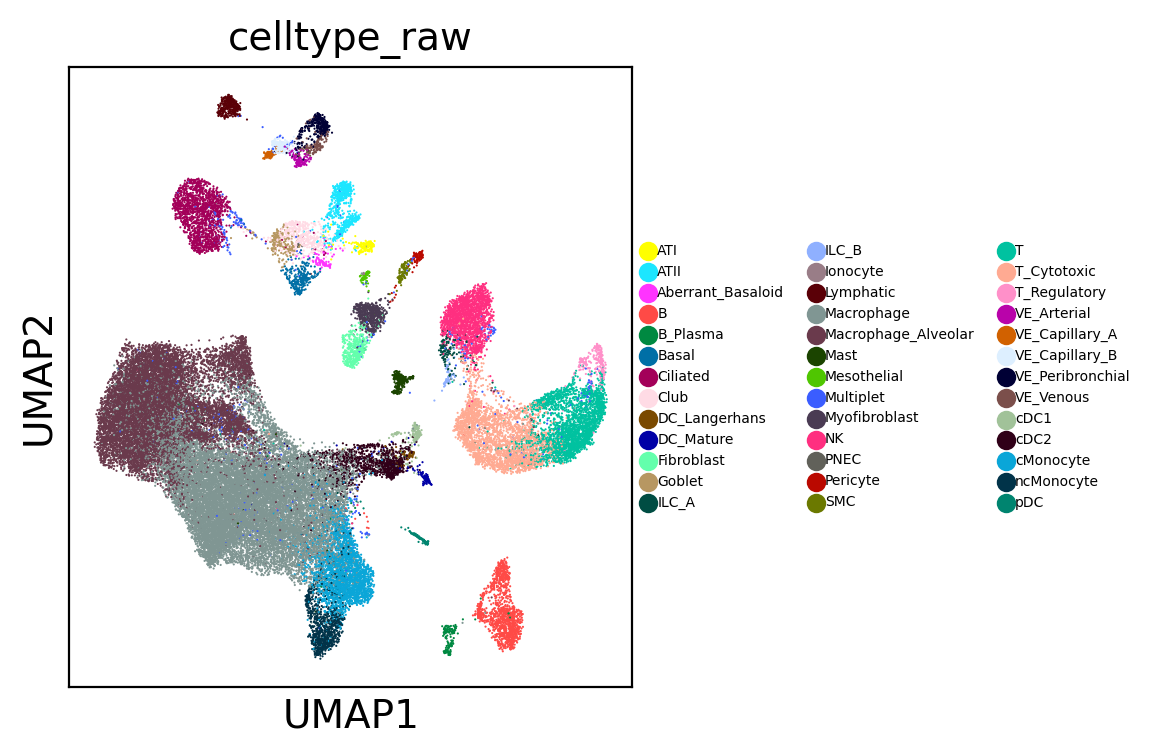

In [11]:
sc.pl.umap(adams, color='celltype_raw', legend_fontsize=5)

Adams et al dataset was not included in the training set, meaning that this is the first time the model has seen this data, yet it is still able to represent the cell types present. 
This dataset has cells sourced from IPF patients, COPD patients, and healthy individuals. Let's assume we are studying the myofibroblasts in IPF patients so we want to perform a query using a myofibroblast from an IPF patient.

We can subset for IPF samples and check the expression of some canonical fibroblast and myofibroblast markers across different samples to ensure we pick a high quality myofibroblast cell.

In [12]:
marker_list =  {
    'Sort' :["THY1", "COL1A1", "COL3A1", "COL6A1", "COL8A1", "COL15A1"],
    'Fibroblast' :["CADM3", "CCDC80", "CD34", "CSF3", "DCN", "FBLN1", "FN1", "HAS1", "HAS2", "LUM", "PDGFRA", "PDGFRB", "PI16", "PLA2G2A", "PLIN2", "PTX3", "VIT"],
    'Myofibroblast' :["CDH11", "COMP", "ELN", "LRRC15", "MMP11", "POSTN"],
    'SmoothMuscle' :["ACTA2", "ACTG2", "CNN1", "DES",  "MYH11", "MYL9", "NOTCH3", "TAGLN", "TPM2"],
}

In [13]:
adams_sub = adams[adams.obs['Disease'] == 'IPF'].copy()

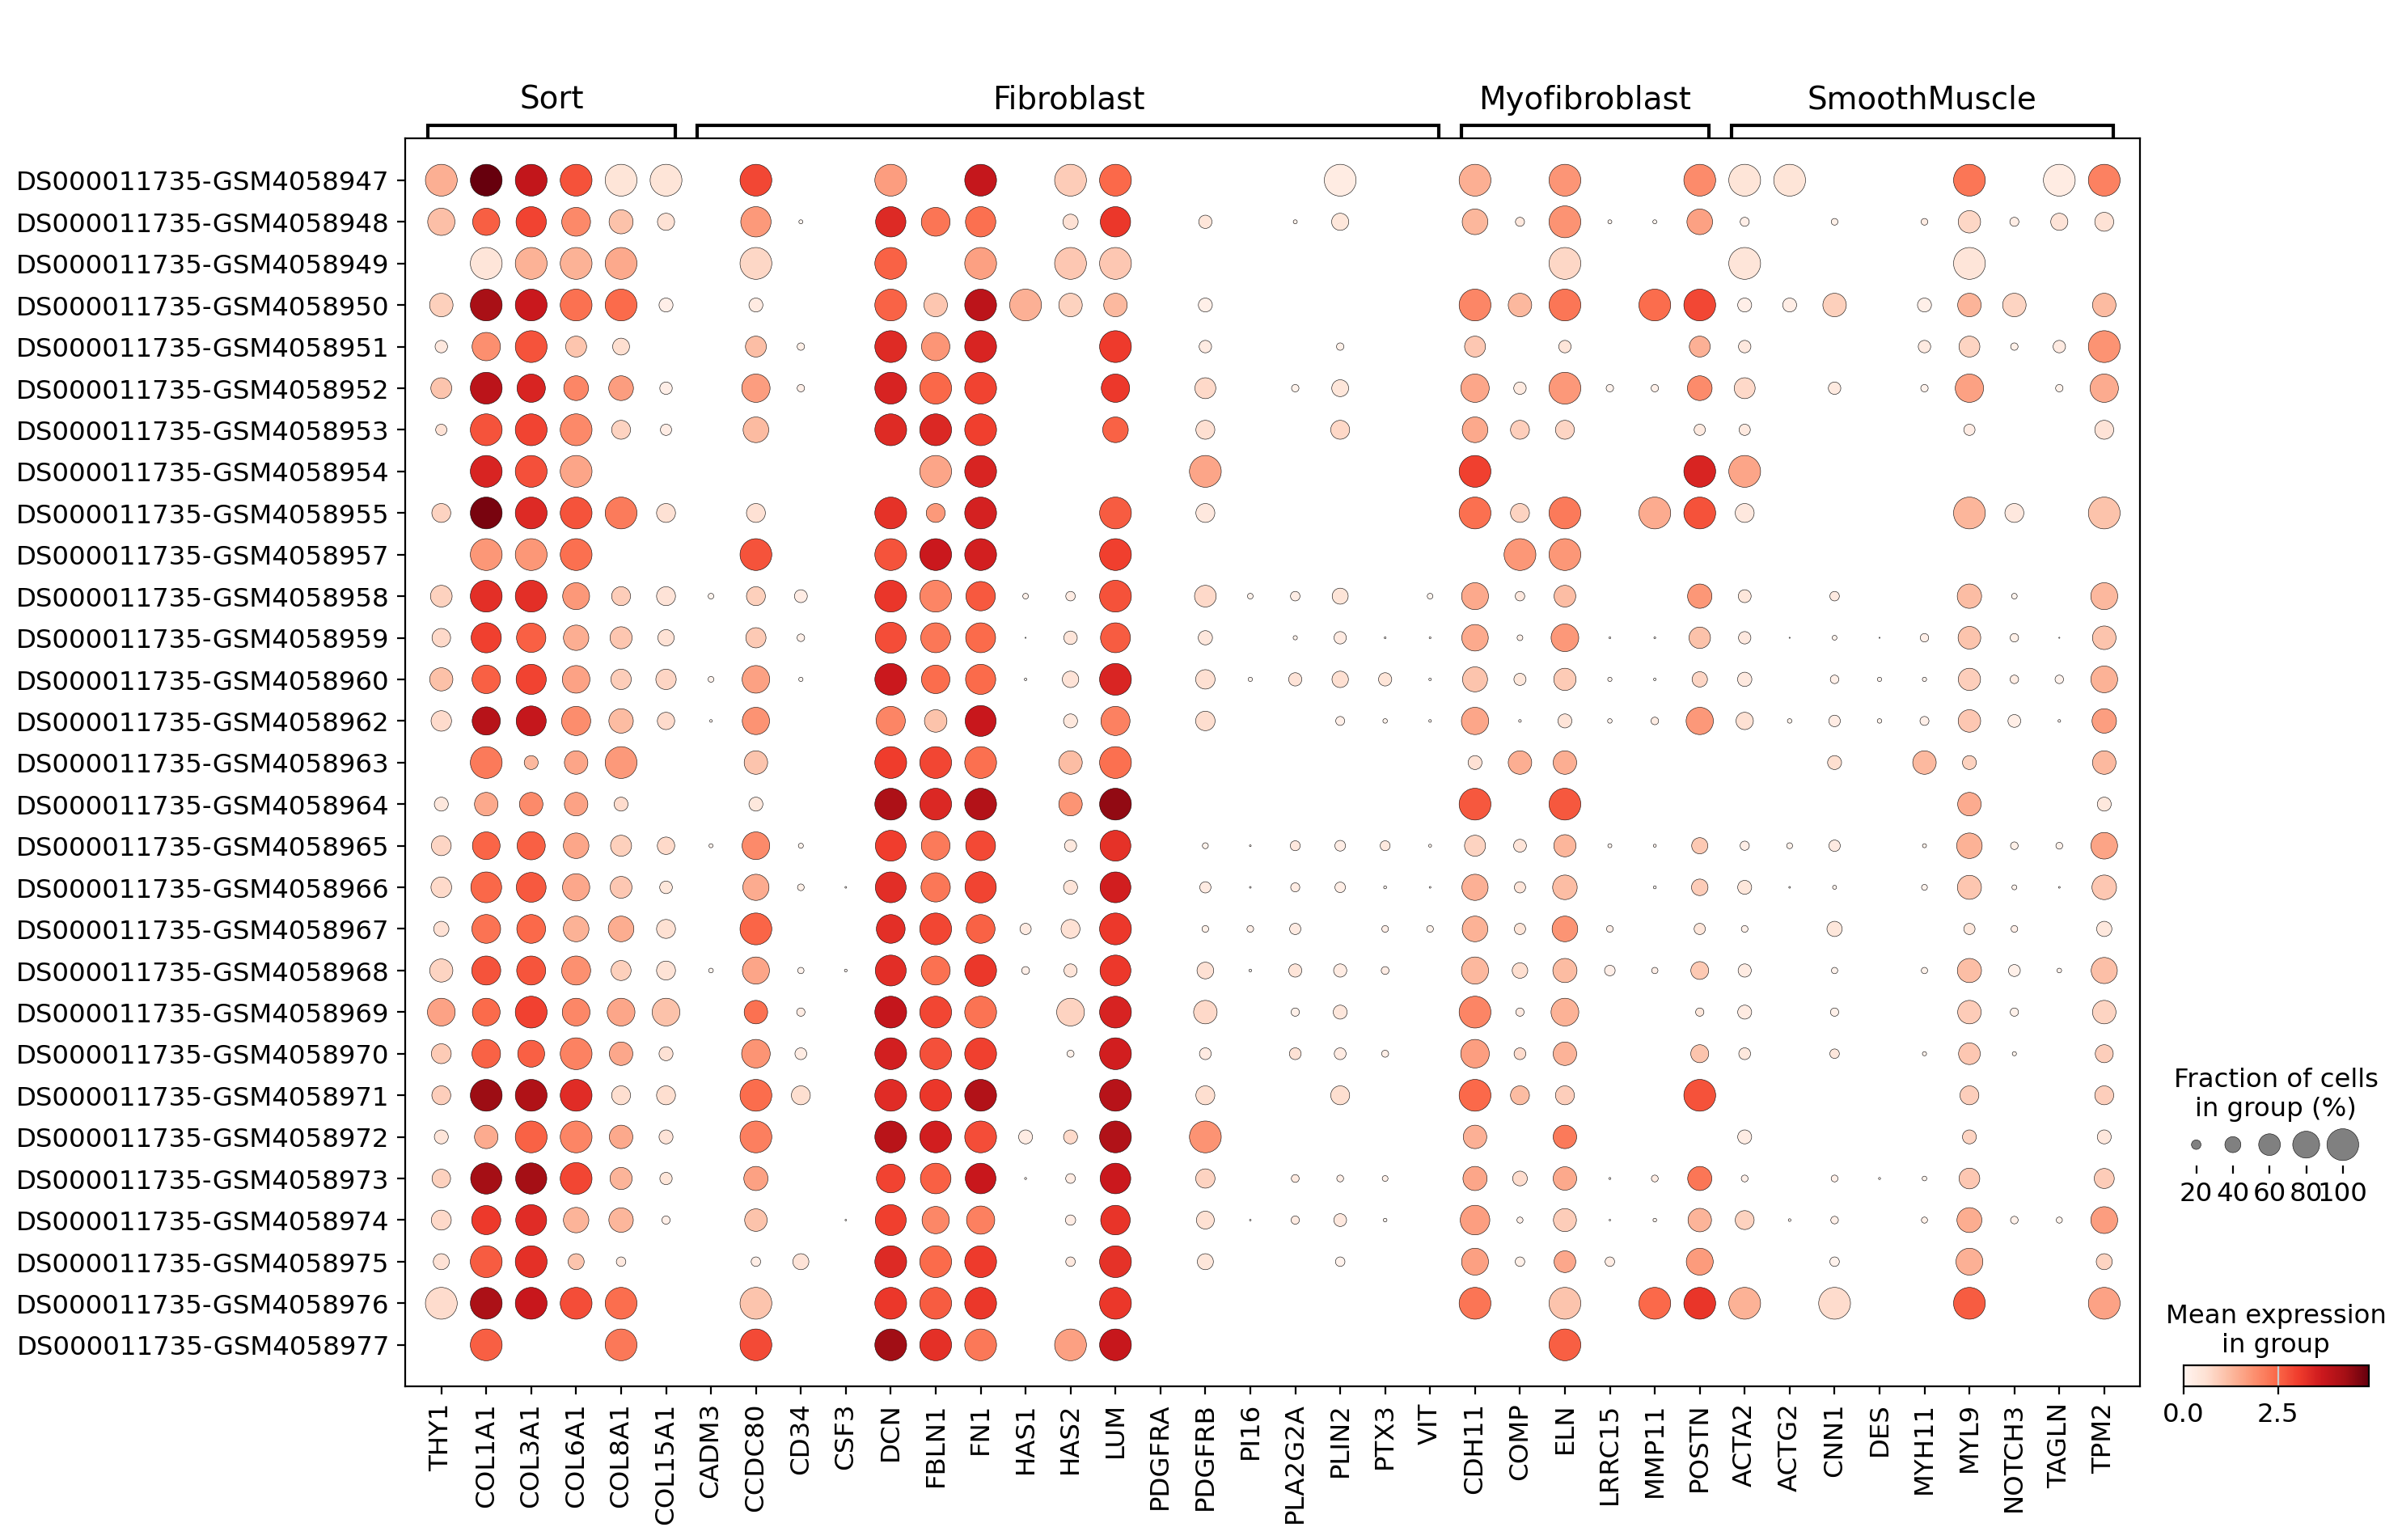

In [14]:
adams_myofib = adams_sub[adams_sub.obs['celltype_name'] == 'myofibroblast cell'].copy()
sc.pl.dotplot(adams_myofib, var_names = marker_list, groupby = 'sample', var_group_rotation = 0)

GSM4058950 contains good quality myofibroblasts (based on the expression of myofibroblast canonical markers) 

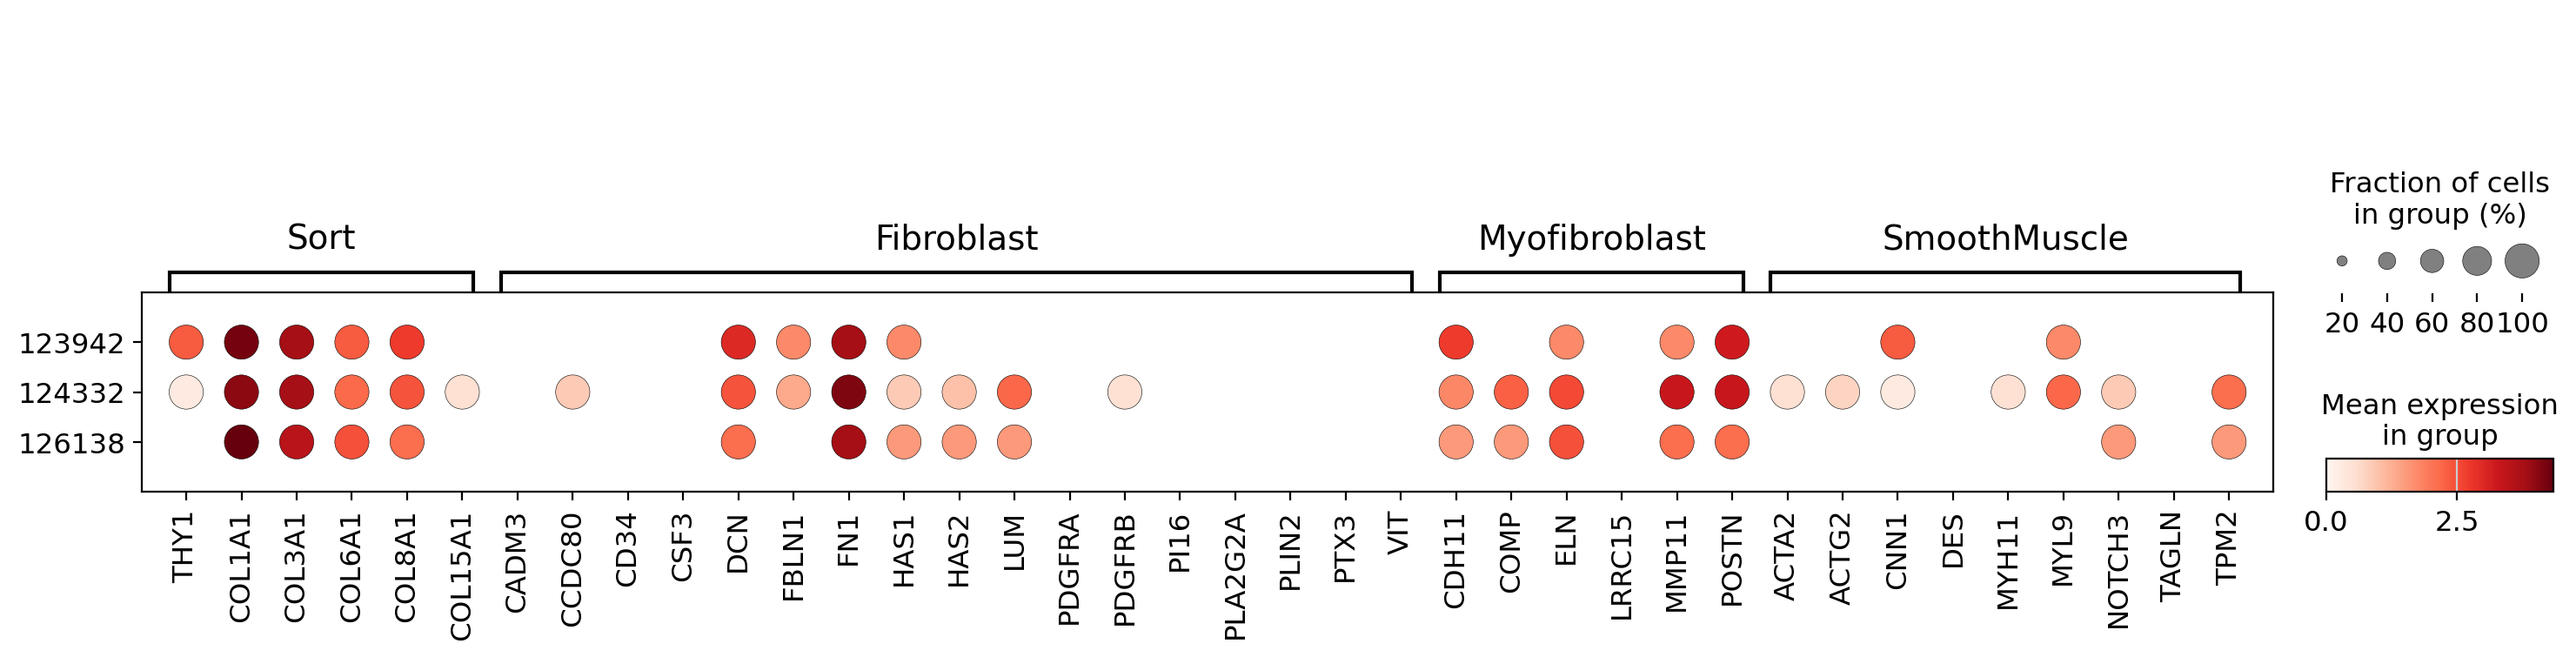

In [15]:
subsample = adams_myofib[adams_myofib.obs['sample'] == 'DS000011735-GSM4058950'].copy()
subsample.obs['cell_id'] = subsample.obs.index 

fig, axes = plt.subplots(1,1, figsize = (15,4))
sc.pl.dotplot(subsample, var_names = marker_list, groupby = 'cell_id', var_group_rotation = 0, ax = axes, show = False)
fig.tight_layout()

We will select cell 123942 for our query. 

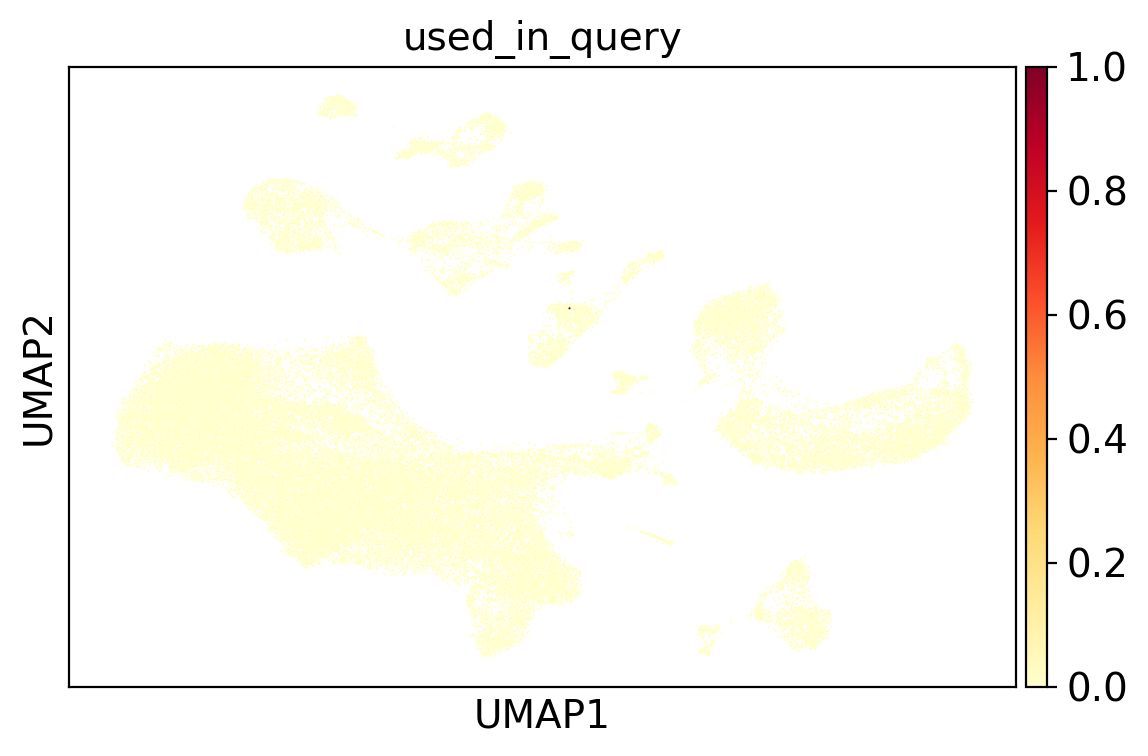

In [16]:
used_in_query = adams.obs.index == '123942'
adams.obs['used_in_query'] = used_in_query.astype(int)
sc.pl.umap(adams, color=['used_in_query'], cmap='YlOrRd')

## 3. Perform cell search
 - Search for k=10000 most simliar cells across 22.7M cell reference and extract metadata for each cell
 - For sub-second searches, with less frills, use cq.get_nearest_neighbors
 - Note: many of the search results will be from the Adams dataset
 
 *Input for cq.search()* 
 - Model embedding which we calculate from cq.get_embeddings() as we did above)
 - k representing the number of neighbours we would like to find
 
 *Output of cq.search()*
 - nn_idxs: indices of neighbour cells in the SCimilarity reference
 - nn_dists: the distance between neighbour cells and the query 
 - metadata: a dataframe containing the metadata associated with each cell
 

In [17]:
query_cell = subsample[subsample.obs.index == '123942']
query_embedding = query_cell.obsm['X_scimilarity']

In [18]:
%%time 
k = 10000
nn_idxs, nn_dists, results_metadata = cq.search(query_embedding, k=k)

CPU times: user 2.3 s, sys: 614 ms, total: 2.92 s
Wall time: 2.93 s


### Interpret results
Now that the query has returned the most similar cells, we can look at the cells to see which studies and conditions they are present in. 

In [19]:
def calculate_disease_proportions(metadata):
    study_proportions = metadata.disease.value_counts()
    return 100*study_proportions / study_proportions.sum()

def plot_proportions(df, title=None):
    ax = df.plot(kind='barh', 
            xlabel='percent of cells',
            title=title, 
            grid=False,
            figsize=(8,5))
    ax.tick_params(axis='y', labelsize=8)
    ax.set_xticklabels([f'{int(tick)}%' for tick in ax.get_xticks()]);
    plt.tight_layout()

#### Exclude self-referencing results
Naturally, queries searching for similar cells will highlight cells from the same study. To get a clearer view of the results, we often exclude those self-referencing hits.

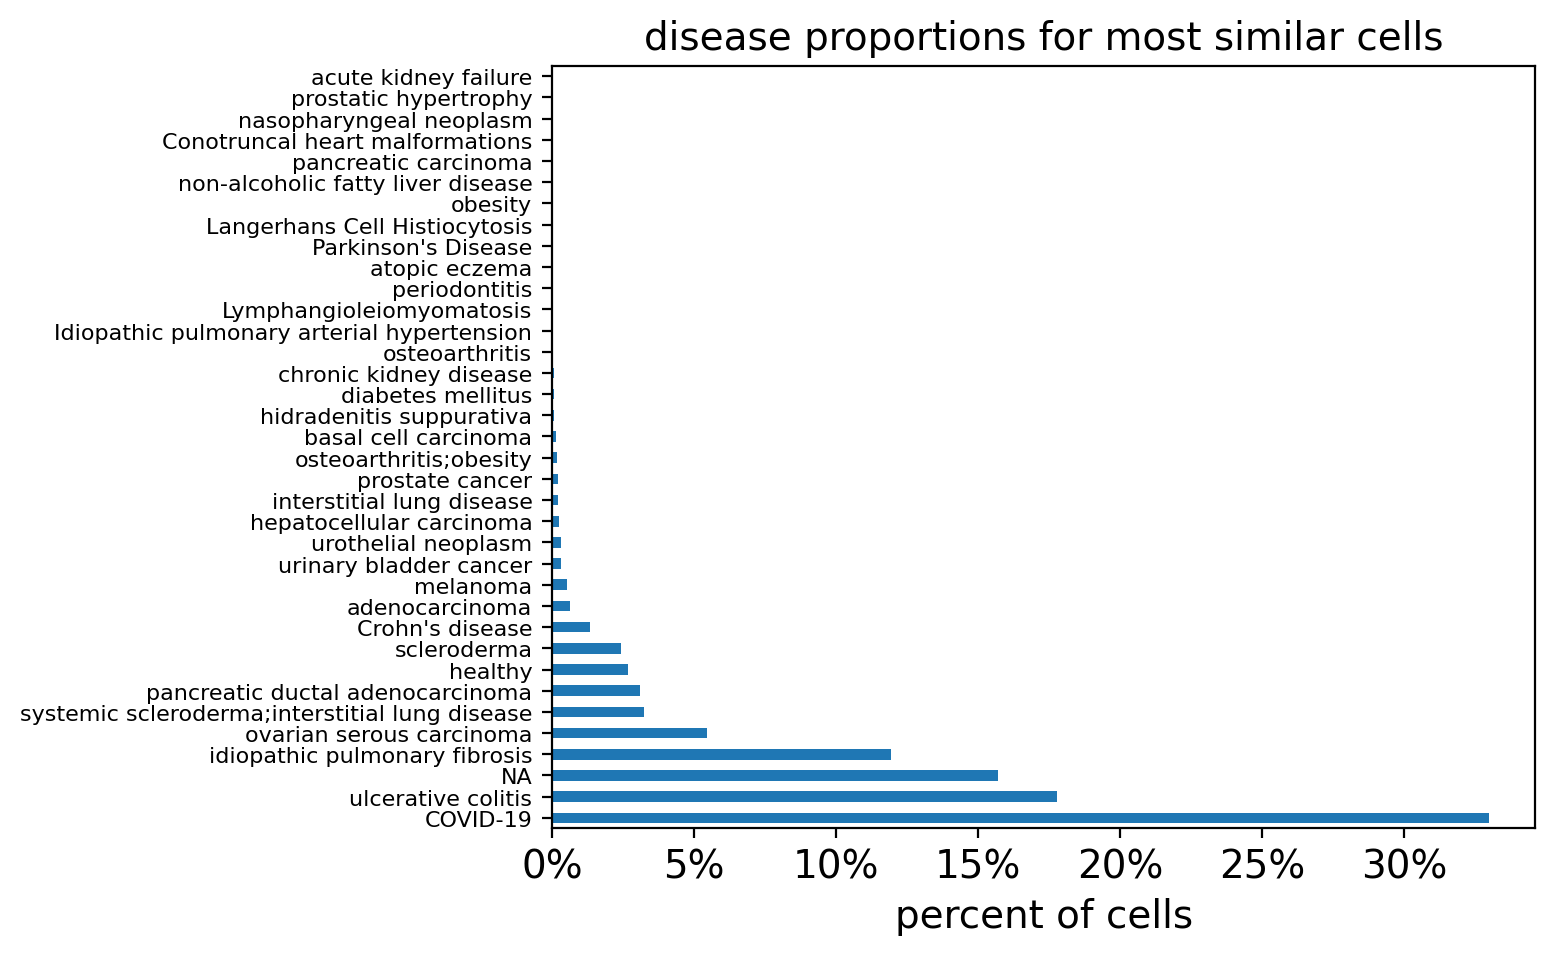

In [20]:
query_study = 'DS000011735'
filtered_result_metadata = results_metadata[results_metadata.study!=query_study]
query_disease_frequencies = calculate_disease_proportions(filtered_result_metadata)
plot_proportions(query_disease_frequencies, title='disease proportions for most similar cells')

This query shows higher proportion of cells in multiple diseases including COVID-19, ulcerative colitis, ILDs, and cancers than healthy cells. However results can be skewed by the imbalanced abundances of diseases and tissues in the query reference. We can test for enrichment by counting the number of predicted myofibroblasts (already precompted in `cq.cell_metadata`) across diseases for both our query hits and the full reference.

#### Get reference cell metadata
Sample metadata has been curated to be able to see tissue, disease, etc for each cell. In this metadata table each row corresponds to a cell that is matched by index across the full knn index and precomputed cell embeddings.

In [21]:
ref_metadata = cq.cell_metadata

#### Compare to background of myofibroblasts across diseases
To see how enriched our results are for a disease of interest, we can visualize this imbalance. 
1. Subset the full reference metadata to cells that are predicted to be myofibroblasts 
2. Tabulate the cell counts by disease state
3. Visualize the proportion of myofibroblasts within the reference collection in different diseases

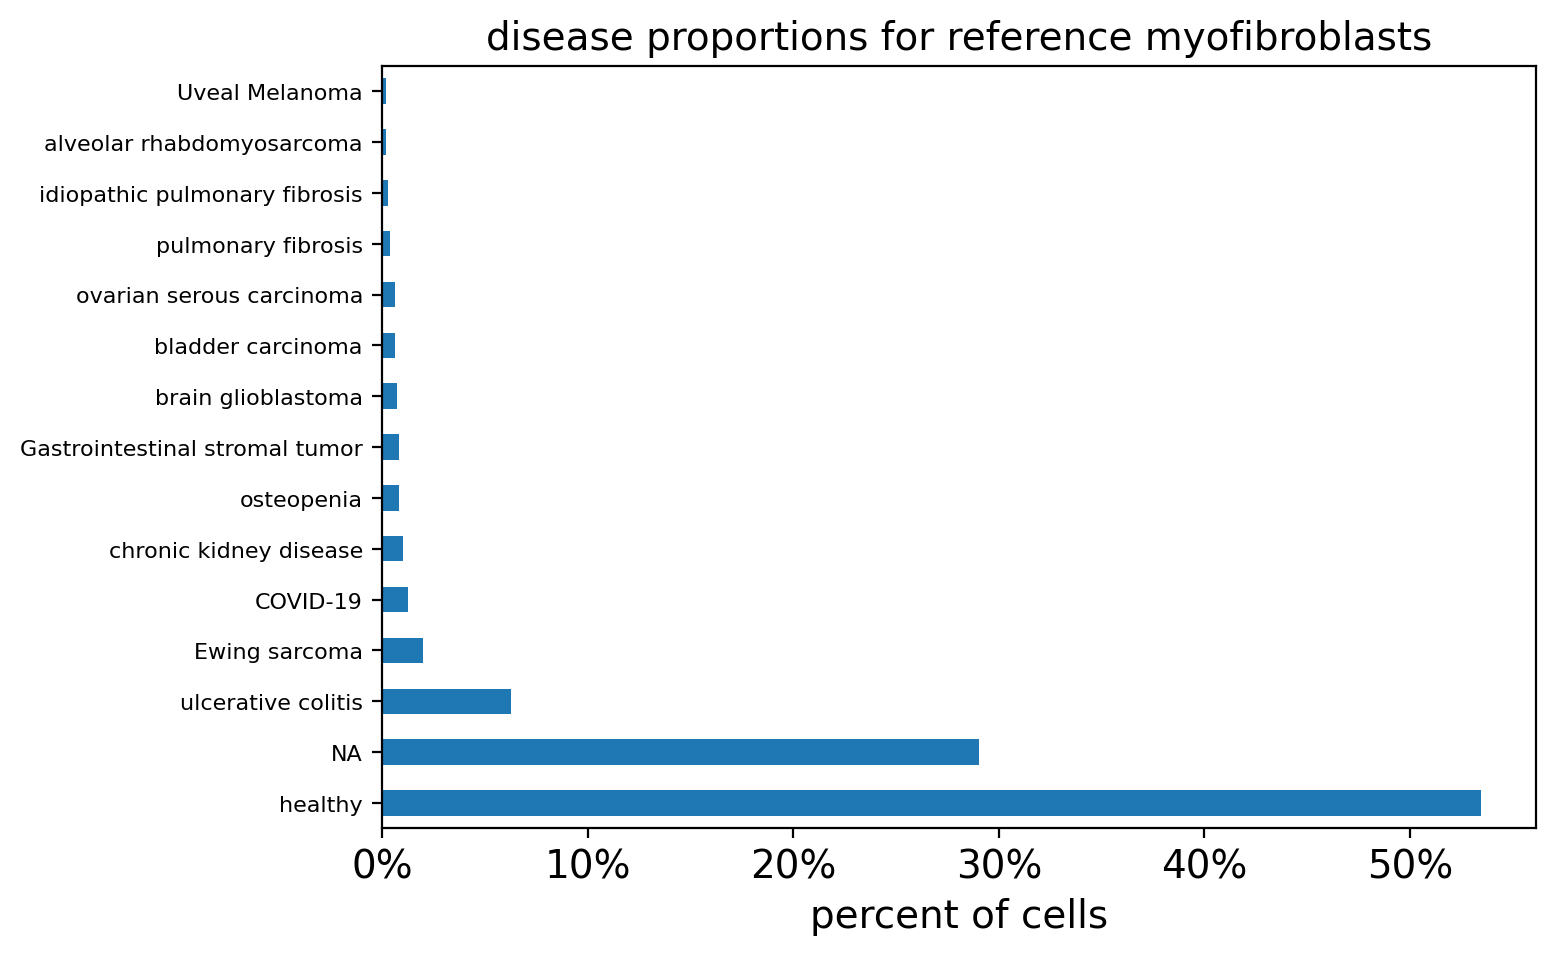

In [22]:
myofib_meta = ref_metadata[ref_metadata.prediction.isin(['myofibroblast cell'])]
query_disease_frequencies = calculate_disease_proportions(myofib_meta)
plot_proportions(query_disease_frequencies[:15], title='disease proportions for reference myofibroblasts')

Over 50% of the myofibroblasts in the reference are from healthy tissues, while in our query they make up less than 5% of the cells most similar to our query. This confirms that these cells are in fact found in multiple conditions as highlighted earlier while they are more rare in healthy samples. 

## Conclusion:
This notebook outlines the basics of how to take a dataset, select a query cell, perform a cell search across our precomputed indices for 22.7M cells and summarize the results. You can use this as a template to expore cell states in other datasets you are interested in. 


 - Keep in mind that the datasets that you analyze with SCimilarity should fit the following criteria:
   - Data generated from 10X Chromium machine (models are trained using this data only).
   - Human scRNA-seq data.
   - Normalized from counts with SCimilarity functions or using the same process. Different normalizations will have poor results.

## Next: Advanced cell search using centroids
This notebook demonstrated the basic cell search principle using SCimilarity. However, a single cell's expression data is noisy and the query results from which can be highly variable even from identical celltypes. This variability can be mitigated by searching centroids.

Check out the next tutorial to learn how to search cell centroids using SCimilarity!